## Centrality Dependence of CNM Effects

### Setup, Import & Preprocess

In [63]:
# === setup & imports ===
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
sys.path.append("./code")  # where your modules live

# nPDF + centrality tools
from npdf_module import (
    NPDFSystem, RpAAnalysis,
    WoodsSaxonPb, CentralityModel, GluonFromGrid,  # SA from grids
    plot_rpa_vs_centrality_hzerr, step_band_xy, band_xy,
)

# eLoss
from eloss_module import load_eloss_run

In [67]:
def load_system(energy="8TeV", *, choose=None, log_level=20):
    cfg = {
        "8TeV": dict(ELOSS_BASE="./input/eloss/pPb8TeV/output_8160GeV_pPb_alpha_constant", NPDF_DIR="./input/npdf/pPb8TeV", SIGMA=71.0, SQRTS=8160.0),
        "5TeV": dict(ELOSS_BASE="./input/eloss/pPb5TeV/output_5020GeV_pPb_alpha_constant", NPDF_DIR="./input/npdf/pPb5TeV", SIGMA=67.2, SQRTS=5023.0),
    }[energy]
    ana  = RpAAnalysis()
    npdf = NPDFSystem.from_folder(cfg["NPDF_DIR"], kick="pp", name=f"p+Pb {cfg['SQRTS']/1000:.2f} TeV")
    rgrid= ana.compute_rpa_grid(npdf.df_pp, npdf.df_pa, npdf.df_errors, join="intersect")
    SA   = GluonFromGrid(npdf.df_pp, npdf.df_pa)
    geom = WoodsSaxonPb()
    model= CentralityModel.from_inputs(SA, geom, b_max=12.0, nb=601)
    E    = load_eloss_run(cfg["ELOSS_BASE"], log_level=20, choose=["output_qhat0_0.051","output_qhat0_0.09"])
    return dict(npdf=npdf, rgrid=rgrid, model=model, E=E, sigma_mb=cfg["SIGMA"],
            energy_label=fr"$\sqrt{{s}}={cfg['SQRTS']/1000:.2f}\,\mathrm{{TeV}}$")

In [68]:
# centrality bin edges for output tables/plots
CENT_EDGES = [0,10,20,40,60,80,100]   # matches your eloss bins by default

# analysis windows
Y_WINDOWS   = [(-1.93, 1.93), (2.03, 3.53), (-4.46, -2.96)]  # example set
PT_RANGE    = (0.1, 20.0)
Y_BINW      = 0.5
PT_BINW     = 2.5
Y_RANGE = (-5, 5) 

# ---------- tiny utilities ----------
C_NPDF, C_ELOSS, C_CNM = "#1f77b4", "#ff7f0e", "#2ca02c"
BAND_ALPHA = 0.25

In [69]:
## Load data
sys8 = load_system("8TeV", choose=["output_qhat0_0.051","output_qhat0_0.09"])
cent_table8 = sys8["model"].centrality_table(CENT_EDGES, sigmaNN_mb=sys8["sigma_mb"])

[INFO] Loaded 0-10
[INFO] Loaded 10-20
[INFO] Loaded 20-40
[INFO] Loaded 40-60
[INFO] Loaded 60-80
[INFO] Loaded 80-100
[INFO] Loaded 0-10
[INFO] Loaded 10-20
[INFO] Loaded 20-40
[INFO] Loaded 40-60
[INFO] Loaded 60-80
[INFO] Loaded 80-100


In [75]:
## Helpers
def _inside_note(ax, y_range, pt_range):
    txt = fr"$y\in[{y_range[0]:.2f},{y_range[1]:.2f}]$" + "\n" + fr"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"
    ax.text(0.02, 0.02, txt, transform=ax.transAxes, ha="left", va="bottom",
            fontsize=10, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7", alpha=0.9))

def _order_by_left(tab):
    # ensure bins are in 0–100 order
    L = tab["cent_bin"].str.replace("%","").str.split("-", expand=True)[0].astype(float).to_numpy()
    return tab.iloc[np.argsort(L)].reset_index(drop=True)

def _as_step_arrays(edges, values_per_bin):
    """
    edges: array like [0,10,20,...,100], len = nbins+1
    values_per_bin: len = nbins
    returns X (len=nbins+1), Y (len=nbins+1) for step(..., where='post')
    """
    edges = np.asarray(edges, float)
    v = np.asarray(values_per_bin, float)
    if len(v) != len(edges)-1:
        raise ValueError("values_per_bin length must be len(edges)-1")
    Y = np.r_[v, v[-1]]
    return edges, Y


# --- tiny helpers / fixes ---
def _clamp_band_to_central(c, lo, hi):
    c  = np.asarray(c,  float)
    lo = np.asarray(lo, float)
    hi = np.asarray(hi, float)
    return c, np.minimum.reduce([lo, c, hi]), np.maximum.reduce([lo, c, hi])

def _bin_mid_labels(edges):
    """Tick positions at bin midpoints + nice 'L-H%' labels."""
    E = np.asarray(edges, float)
    mids = 0.5*(E[:-1] + E[1:])
    labels = [f"{int(E[i])}-{int(E[i+1])}%" for i in range(len(E)-1)]
    return mids, labels

def _box_note(ax, lines, xy=(0.02,0.02), ha="left", va="bottom"):
    txt = "\n".join(lines)
    ax.text(xy[0], xy[1], txt, transform=ax.transAxes, ha=ha, va=va,
            fontsize=10, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7", alpha=0.9))
    


import numpy as np

def _rel_band(c, lo, hi):
    c, lo, hi = map(np.asarray, (c, lo, hi))
    eps=1e-14
    rp = np.where(np.abs(c)>eps, (hi - c)/c, 0.0)
    rm = np.where(np.abs(c)>eps, (c - lo)/c, 0.0)
    return rm, rp

def combine_product_asym(Ac, Alo, Ahi, Bc, Blo, Bhi):
    Ac, Alo, Ahi = map(lambda x: np.asarray(x, float), (Ac, Alo, Ahi))
    Bc, Blo, Bhi = map(lambda x: np.asarray(x, float), (Bc, Blo, Bhi))
    Arm, Arp = _rel_band(Ac, Alo, Ahi)
    Brm, Brp = _rel_band(Bc, Blo, Bhi)
    Cc = Ac * Bc
    Crel_p = np.sqrt(Arp**2 + Brp**2)
    Crel_m = np.sqrt(Arm**2 + Brm**2)
    return Cc, Cc*(1.0 - Crel_m), Cc*(1.0 + Crel_p)

def _ensure_band_cols(df, c="RpA", lo="lo", hi="hi", d="dRpA"):
    """Ensure a (central,lo,hi) band exists. If ensemble lo/hi exist, keep them;
       else fall back to ±dRpA; else a degenerate band."""
    df = df.copy()
    if lo not in df.columns or hi not in df.columns:
        if d in df.columns:
            df[lo] = df[c] - df[d]
            df[hi] = df[c] + df[d]
        else:
            df[lo] = df[c]
            df[hi] = df[c]
    return df

def _cent_label(L, R):
    L=float(L); R=float(R)
    f = lambda x: (str(int(round(x))) if abs(x-round(x))<1e-8 else f"{x:g}")
    return f"{f(L)}-{f(R)}%"

def _parse_edges_from_labels(labels):
    # from ["0-10%","10-20%",...,"80-100%"] → [0,10,20,...,100]
    bounds=[]
    for s in labels:
        a,b = s.replace("%","").split("-")
        bounds += [float(a), float(b)]
    u = sorted(set(bounds))
    return u

# normalize "0–10%", "0-10" etc. → "0-10%"
def _norm_cent(s: str) -> str:
    s = str(s).replace("–","-").replace("%","").strip()
    a,b = [float(x) for x in s.split("-")]
    fa=lambda x: (str(int(x)) if abs(x-round(x))<1e-8 else f"{x:g}")
    return f"{fa(a)}-{fa(b)}%"

# find best-matching eLoss tag for a requested label (max overlap in %) 
def _overlap(a, b):
    (aL,aR) = [float(x) for x in str(a).replace("%","").split("-")]
    (bL,bR) = [float(x) for x in str(b).replace("%","").split("-")]
    return max(0.0, min(aR,bR) - max(aL,bL))

def eloss_tag_for(label: str) -> str:
    want = norm_cent(label)
    pool = [norm_cent(t) for t in E.available_cent_tags]
    # exact:
    if want in pool: return want
    # best overlap:
    best = max(pool, key=lambda t: _overlap(want, t))
    return best

# centrality-averaged eLoss with band (half-width from ensemble envelope if present)
def eloss_mean_band(label: str, y_range, pt_range):
    tag = eloss_tag_for(label)
    c  = E.mean_rpa_over_y_and_pt(tag.replace("%",""), y_range, pt_range)
    try:
        hw = E.mean_rpa_err_over_y_and_pt(tag.replace("%",""), y_range, pt_range)
        return float(c), float(c - hw), float(c + hw)
    except Exception:
        # single run without band
        return float(c), float(c), float(c)

## RpA vs Centrality

In [76]:
def cnm_vs_centrality_tables(y_range, pt_range, cent_edges,
                             *, model, npdf, rgrid, eloss_run, sigma_mb):
    """
    Returns a DataFrame with columns:
      cent_bin, (nPDF) r_central,r_lo,r_hi,  (eLoss) eloss,eloss_lo,eloss_hi,
      (CNM) cnm_c,cnm_lo,cnm_hi
    Integrated over y_range × pt_range; centrality bins = cent_edges (full 0–100%).
    """
    # 1) nPDF band integrated over (y, pT) in each centrality bin
    tabN = model.rpa_vs_centrality_integrated(
        rgrid, npdf.df_pa, cent_edges,
        y_min=y_range[0], y_max=y_range[1],
        pt_min=pt_range[0], pt_max=pt_range[1],
        sigmaNN_mb=sigma_mb, weight="inelastic", verbose=False
    ).copy()
    if tabN.empty:
        return pd.DataFrame(columns=["cent_bin","r_central","r_lo","r_hi","eloss","eloss_lo","eloss_hi","cnm_c","cnm_lo","cnm_hi"])

    # 2) eLoss mean ± band per centrality (auto-works for single run or ensemble)
    e_c, e_lo, e_hi = [], [], []
    for lab in tabN["cent_bin"]:
        tag = _norm_cent(lab).replace("%","")
        try:
            c  = eloss_run.mean_rpa_over_y_and_pt(tag, y_range, pt_range)
            hw = eloss_run.mean_rpa_err_over_y_and_pt(tag, y_range, pt_range)  # half-width if ensemble
            lo, hi = float(c - hw), float(c + hw)
        except Exception:
            # fallback: average eLoss over y, then over pt if needed
            # (kept simple; your ELossRun already has the mean_* helpers)
            Y = eloss_run.rpa_vs_y(cent_tag=tag, y_edges=np.arange(y_range[0], y_range[1]+1e-12, 0.5), pt_range=pt_range)
            c = float(np.nanmean(np.asarray(Y.get("RpA", Y.get("c", np.nan)))))
            lo = float(np.nanmin(np.asarray(Y.get("lo", np.array([c])))))
            hi = float(np.nanmax(np.asarray(Y.get("hi", np.array([c])))))
        e_c.append(c); e_lo.append(lo); e_hi.append(hi)

    tabN["eloss"]     = np.asarray(e_c,  float)
    tabN["eloss_lo"]  = np.asarray(e_lo, float)
    tabN["eloss_hi"]  = np.asarray(e_hi, float)

    # 3) CNM = nPDF × eLoss with asymmetric propagation
    Cc, Clo, Chi = combine_product_asym(
        tabN["r_central"], tabN["r_lo"], tabN["r_hi"],
        tabN["eloss"],     tabN["eloss_lo"], tabN["eloss_hi"]
    )
    tabN["cnm_c"], tabN["cnm_lo"], tabN["cnm_hi"] = Cc, Clo, Chi

    # canonicalize labels
    tabN["cent_bin"] = tabN["cent_bin"].map(_norm_cent)
    return _order_by_left(tabN)


def plot_rpa_vs_centrality(tab, *, cent_edges, cent_table, y_range, pt_range,
                           xmode="centrality", components=("npdf","eloss","cnm"),
                           ax=None, ylim=(0.0,1.5), xlim=None, energy_label=None):
    comps = {c.lower() for c in components}
    T = _order_by_left(tab).copy()
    if ax is None:
        fig, ax = plt.subplots()

    if xmode.lower() == "centrality":
        X, n_c  = _as_step_arrays(cent_edges, T["r_central"])
        _, n_lo = _as_step_arrays(cent_edges, T["r_lo"])
        _, n_hi = _as_step_arrays(cent_edges, T["r_hi"])
        _, e_c  = _as_step_arrays(cent_edges, T["eloss"])
        _, e_lo = _as_step_arrays(cent_edges, T["eloss_lo"])
        _, e_hi = _as_step_arrays(cent_edges, T["eloss_hi"])
        _, c_c  = _as_step_arrays(cent_edges, T["cnm_c"])
        _, c_lo = _as_step_arrays(cent_edges, T["cnm_lo"])
        _, c_hi = _as_step_arrays(cent_edges, T["cnm_hi"])

        # --- keep central inside the band (safety clamp) ---
        n_c, n_lo, n_hi = _clamp_band_to_central(n_c, n_lo, n_hi)
        e_c, e_lo, e_hi = _clamp_band_to_central(e_c, e_lo, e_hi)
        c_c, c_lo, c_hi = _clamp_band_to_central(c_c, c_lo, c_hi)

        if "npdf" in comps:
            ax.fill_between(X, n_lo, n_hi, color=C_NPDF, alpha=BAND_ALPHA, step="post")
            ax.plot(X, n_c, color=C_NPDF, lw=2, label="nPDF", drawstyle="steps-post")
        if "eloss" in comps:
            ax.fill_between(X, e_lo, e_hi, color=C_ELOSS, alpha=BAND_ALPHA, step="post")
            ax.plot(X, e_c, color=C_ELOSS, lw=2, label="eLoss", drawstyle="steps-post")
        if "cnm" in comps:
            ax.fill_between(X, c_lo, c_hi, color=C_CNM, alpha=BAND_ALPHA, step="post")
            ax.plot(X, c_c, color=C_CNM, lw=2, label=r"CNM = nPDF$\times$eLoss", drawstyle="steps-post")

        ax.set_xlabel("Centrality [%]")
        ax.set_xlim(0, 100)
        mids, labels = _bin_mid_labels(cent_edges)
        ax.set_xticks(mids); ax.set_xticklabels(labels, rotation=0)

    else:  # x = <N_coll>
        CT = _order_by_left(cent_table)
        x = CT["N_coll"].to_numpy(float)
        order = np.argsort(x); x = x[order]

        get = lambda col: np.asarray(T[col].to_numpy(float))[order]
        n_c, n_lo, n_hi = _clamp_band_to_central(get("r_central"), get("r_lo"), get("r_hi"))
        e_c, e_lo, e_hi = _clamp_band_to_central(get("eloss"),     get("eloss_lo"), get("eloss_hi"))
        c_c, c_lo, c_hi = _clamp_band_to_central(get("cnm_c"),     get("cnm_lo"),   get("cnm_hi"))

        if "npdf" in comps:
            ax.fill_between(x, n_lo, n_hi, color=C_NPDF, alpha=BAND_ALPHA)
            ax.plot(x, n_c, color=C_NPDF, lw=2, label="nPDF")
        if "eloss" in comps:
            ax.fill_between(x, e_lo, e_hi, color=C_ELOSS, alpha=BAND_ALPHA)
            ax.plot(x, e_c, color=C_ELOSS, lw=2, label="eLoss")
        if "cnm" in comps:
            ax.fill_between(x, c_lo, c_hi, color=C_CNM, alpha=BAND_ALPHA)
            ax.plot(x, c_c, color=C_CNM, lw=2, label=r"CNM = nPDF$\times$eLoss")

        ax.set_xlabel(r"$\langle N_{\mathrm{coll}}\rangle$")
        if xlim: ax.set_xlim(*xlim)

    ax.set_ylabel(r"$R_{pA}$")
    if ylim: ax.set_ylim(*ylim)
    # in-plot notes (publication style): energy + y-window (no title)
    lines = []
    if energy_label: lines.append(energy_label)
    if y_range:      lines.append(fr"${y_range[0]:.2f}<y<{y_range[1]:.2f}$")
    _box_note(ax, lines, xy=(0.02,0.02), ha="left", va="bottom")

    ax.legend(frameon=False, loc="best")
    ax.grid(alpha=0.25)
    return ax

def figure_rpa_vs_centrality_3panels(y_windows, *, cent_edges, cent_table,
                                     model, npdf, rgrid, eloss_run, sigma_mb,
                                     components=("npdf","eloss","cnm"),
                                     xmode="centrality", ylim=(0.3,1.15),
                                     energy_label=None, figsize=(14,4.2)):
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True, constrained_layout=True)
    for ax, ywin in zip(axes, y_windows):
        tab = cnm_vs_centrality_tables(
            y_range=ywin, pt_range=PT_RANGE, cent_edges=cent_edges,
            model=model, npdf=npdf, rgrid=rgrid, eloss_run=eloss_run, sigma_mb=sigma_mb
        )
        plot_rpa_vs_centrality(
            tab, cent_edges=cent_edges, cent_table=cent_table,
            y_range=ywin, pt_range=PT_RANGE, xmode=xmode,
            components=components, ax=ax, ylim=ylim, energy_label=energy_label
        )
    return fig, axes

(<Figure size 1400x420 with 3 Axes>,
 array([<Axes: xlabel='Centrality [%]', ylabel='$R_{pA}$'>,
        <Axes: xlabel='Centrality [%]', ylabel='$R_{pA}$'>,
        <Axes: xlabel='Centrality [%]', ylabel='$R_{pA}$'>], dtype=object))

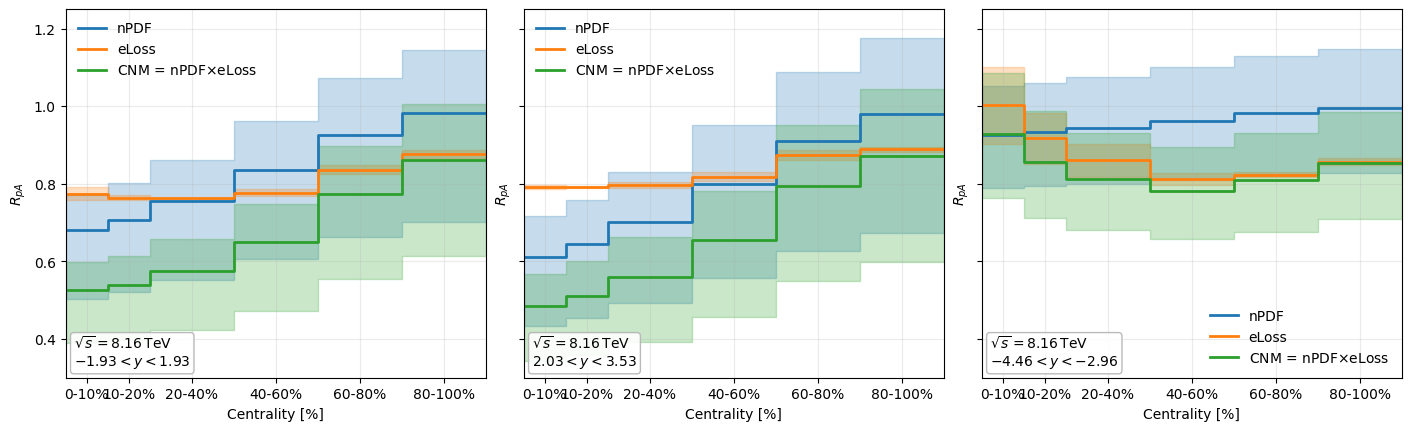

In [77]:

figure_rpa_vs_centrality_3panels(
    Y_WINDOWS, cent_edges=CENT_EDGES, cent_table=cent_table8,
    model=sys8["model"], npdf=sys8["npdf"], rgrid=sys8["rgrid"], eloss_run=sys8["E"],
    sigma_mb=sys8["sigma_mb"], components=("npdf","eloss","cnm"),
    xmode="centrality", ylim=(0.30,1.25), energy_label=sys8["energy_label"]
)

## RpA vs Rapidity

In [80]:
def cnm_vs_y_in_cent(label, y_binw, pt_range, *, model, npdf, rgrid, eloss_run, sigma_mb):
    # nPDF band per y-bin
    bands = model.rpa_vs_y_in_centrality_bins(
        rgrid, npdf.df_pa, eloss_run.centrality_edges, y_width=float(y_binw),
        pt_min=pt_range[0], pt_max=pt_range[1], sigmaNN_mb=sigma_mb, verbose=False
    )
    d = dict(bands)
    key = _norm_cent(label)
    # best match key
    k2 = None
    for k in d.keys():
        if _norm_cent(k)==key: k2=k; break
    if k2 is None: return pd.DataFrame()
    dfN = d[k2].copy()
    if dfN.empty: return dfN

    # ELoss band per same y-bins
    tag = key.replace("%","")
    yL = dfN["y_left"].to_numpy(float)
    dy = (yL[1]-yL[0]) if len(yL)>1 else float(y_binw)
    y_edges = np.arange(yL[0], yL[-1]+dy+1e-12, dy)
    dfE = eloss_run.rpa_vs_y(cent_tag=tag, y_edges=y_edges, pt_range=pt_range).rename(
        columns={"y_mid":"y","RpA":"eloss","lo":"eloss_lo","hi":"eloss_hi"}
    )
    # defaults for single-run
    if "eloss_lo" not in dfE: dfE["eloss_lo"]=dfE["eloss"]
    if "eloss_hi" not in dfE: dfE["eloss_hi"]=dfE["eloss"]

    # combine to CNM at each bin center
    yC = 0.5*(dfN["y_left"]+dfN["y_right"])
    Nc, Nlo, Nhi = dfN["r_central"].to_numpy(float), dfN["r_lo"].to_numpy(float), dfN["r_hi"].to_numpy(float)
    Ec  = np.interp(yC, dfE["y"], dfE["eloss"])
    Elo = np.interp(yC, dfE["y"], dfE["eloss_lo"])
    Ehi = np.interp(yC, dfE["y"], dfE["eloss_hi"])
    Cc, Clo, Chi = combine_product_asym(Nc, Nlo, Nhi, Ec, Elo, Ehi)

    out = pd.DataFrame({"y":yC, "npdf":Nc, "npdf_lo":Nlo, "npdf_hi":Nhi,
                        "eloss":Ec, "eloss_lo":Elo, "eloss_hi":Ehi,
                        "cnm":Cc, "cnm_lo":Clo, "cnm_hi":Chi})
    return out

def figure_rpa_vs_y_per_centrality(*, y_binw=0.5, pt_range=(0.1,20.0),
                                   model, npdf, rgrid, eloss_run, sigma_mb,
                                   components=("npdf","eloss","cnm"),
                                   ylim=(0.3,1.15), ncols=3, energy_label=None):
    comps = {c.lower() for c in components}
    # use the model's own centrality binning (matches eLoss tags)
    labs = [str(x) for x in model.centrality_table(getattr(eloss_run,"centrality_edges",CENT_EDGES),
                                                   sigmaNN_mb=sigma_mb)["cent_bin"]]
    labs = [_norm_cent(L) for L in labs]
    n = len(labs); ncols = int(min(ncols, n)); nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.6*ncols, 3.8*nrows), sharey=True, constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, lab in zip(axes, labs):
        df = cnm_vs_y_in_cent(lab, y_binw, pt_range, model=model, npdf=npdf, rgrid=rgrid,
                              eloss_run=eloss_run, sigma_mb=sigma_mb)
        if df.empty:
            ax.set_visible(False); continue

        if "npdf" in comps:
            c, lo, hi = _clamp_band_to_central(df["npdf"], df["npdf_lo"], df["npdf_hi"])
            ax.fill_between(df["y"], lo, hi, alpha=BAND_ALPHA, color=C_NPDF, label="nPDF")
            ax.plot(df["y"], c, color=C_NPDF, lw=2)
        if "eloss" in comps:
            c, lo, hi = _clamp_band_to_central(df["eloss"], df["eloss_lo"], df["eloss_hi"])
            ax.fill_between(df["y"], lo, hi, alpha=BAND_ALPHA, color=C_ELOSS, label="eLoss")
            ax.plot(df["y"], c, color=C_ELOSS, lw=2)
        if "cnm" in comps:
            c, lo, hi = _clamp_band_to_central(df["cnm"], df["cnm_lo"], df["cnm_hi"])
            ax.fill_between(df["y"], lo, hi, alpha=BAND_ALPHA, color=C_CNM, label="CNM")
            ax.plot(df["y"], c, color=C_CNM, lw=2)

        ax.set_title(lab)
        ax.set_xlabel("y"); ax.set_ylabel(r"$R_{pA}$"); ax.set_ylim(*ylim)
        note = [fr"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"]
        if energy_label: note.insert(0, energy_label)
        _box_note(ax, note, xy=(0.02,0.02))
        ax.legend(frameon=False, fontsize=9)

    for ax in axes[len(labs):]: ax.axis("off")
    return fig, axes

(<Figure size 1380x760 with 6 Axes>,
 array([<Axes: title={'center': '0-10%'}, xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: title={'center': '10-20%'}, xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: title={'center': '20-40%'}, xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: title={'center': '40-60%'}, xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: title={'center': '60-80%'}, xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: title={'center': '80-100%'}, xlabel='y', ylabel='$R_{pA}$'>],
       dtype=object))

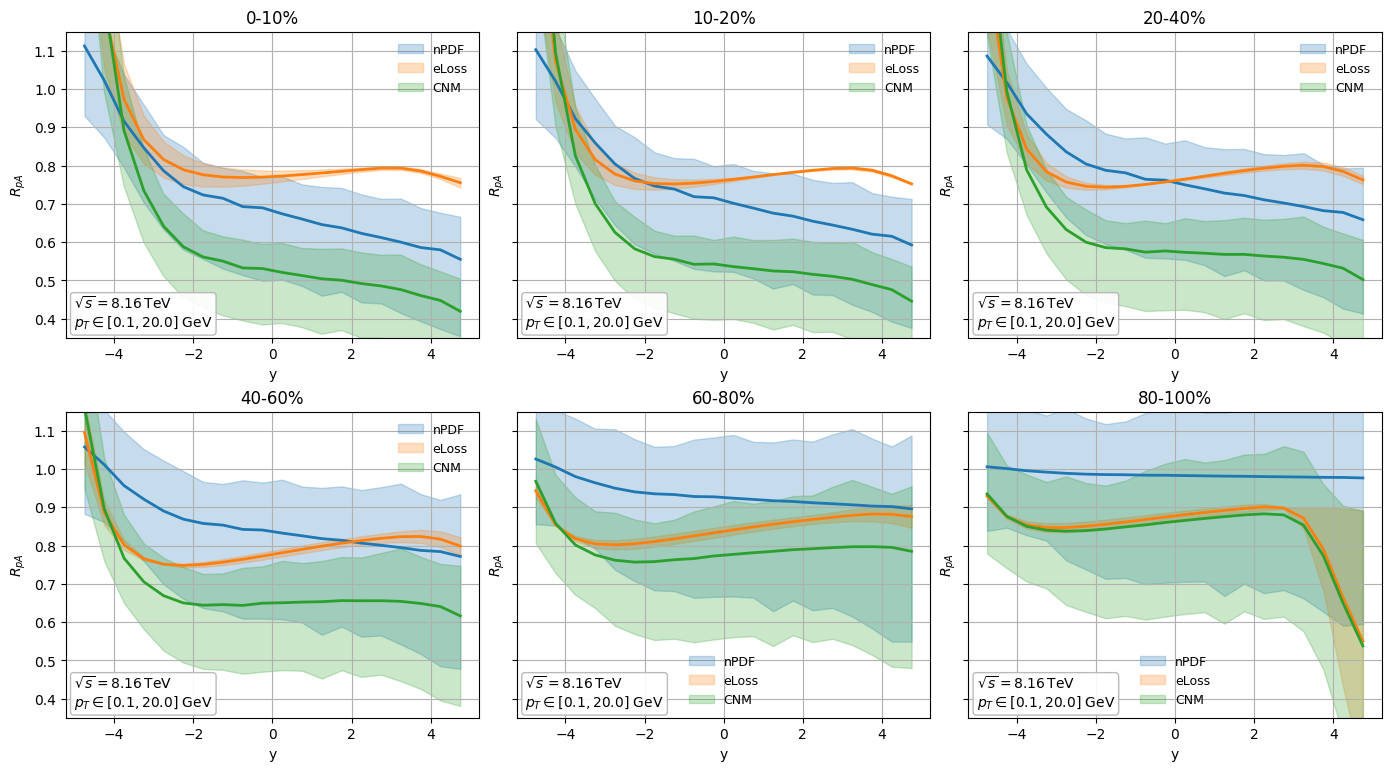

In [81]:
figure_rpa_vs_y_per_centrality(
    y_binw=Y_BINW, pt_range=PT_RANGE,
    model=sys8["model"], npdf=sys8["npdf"], rgrid=sys8["rgrid"], eloss_run=sys8["E"],
    sigma_mb=sys8["sigma_mb"], components=("npdf","eloss","cnm"),
    ylim=(0.35,1.15), ncols=3, energy_label=sys8["energy_label"]
)

## RpA vs Transverse Momentum

In [82]:
def cnm_vs_pt_in_cent(label, y_range, pt_binw, *, model, npdf, rgrid, eloss_run, sigma_mb):
    # nPDF band per pT bin
    bands = model.rpa_vs_pt_in_centrality_bins(
        rgrid, npdf.df_pa, eloss_run.centrality_edges,
        y_min=y_range[0], y_max=y_range[1], pt_width=float(pt_binw),
        sigmaNN_mb=sigma_mb, verbose=False
    )
    d = dict(bands)
    key = _norm_cent(label)
    k2 = None
    for k in d.keys():
        if _norm_cent(k)==key: k2=k; break
    if k2 is None: return pd.DataFrame()
    dfN = d[k2].copy()
    if dfN.empty: return dfN

    # ELoss band per same pT bins
    tag = key.replace("%","")
    pL = dfN["pt_left"].to_numpy(float)
    dp = (pL[1]-pL[0]) if len(pL)>1 else float(pt_binw)
    pt_edges = np.arange(pL[0], pL[-1]+dp+1e-12, dp)
    dfE = eloss_run.rpa_vs_pt(cent_tag=tag, y_range=y_range, pt_edges=pt_edges).rename(
        columns={"pt_mid":"pt","RpA":"eloss","lo":"eloss_lo","hi":"eloss_hi"}
    )
    if "eloss_lo" not in dfE: dfE["eloss_lo"]=dfE["eloss"]
    if "eloss_hi" not in dfE: dfE["eloss_hi"]=dfE["eloss"]

    pC = 0.5*(dfN["pt_left"]+dfN["pt_right"])
    Nc, Nlo, Nhi = dfN["r_central"].to_numpy(float), dfN["r_lo"].to_numpy(float), dfN["r_hi"].to_numpy(float)
    Ec  = np.interp(pC, dfE["pt"], dfE["eloss"])
    Elo = np.interp(pC, dfE["pt"], dfE["eloss_lo"])
    Ehi = np.interp(pC, dfE["pt"], dfE["eloss_hi"])
    Cc, Clo, Chi = combine_product_asym(Nc, Nlo, Nhi, Ec, Elo, Ehi)

    out = pd.DataFrame({"pt":pC, "npdf":Nc, "npdf_lo":Nlo, "npdf_hi":Nhi,
                        "eloss":Ec, "eloss_lo":Elo, "eloss_hi":Ehi,
                        "cnm":Cc, "cnm_lo":Clo, "cnm_hi":Chi})
    return out

def figure_rpa_vs_pt_per_centrality(*, y_range, pt_binw=2.5,
                                    model, npdf, rgrid, eloss_run, sigma_mb,
                                    components=("npdf","eloss","cnm"),
                                    ylim=(0.3,1.15), xlim=(0.0,20.0),
                                    ncols=3, energy_label=None):
    comps = {c.lower() for c in components}
    labs = [str(x) for x in model.centrality_table(getattr(eloss_run,"centrality_edges",CENT_EDGES),
                                                   sigmaNN_mb=sigma_mb)["cent_bin"]]
    labs = [_norm_cent(L) for L in labs]
    n = len(labs); ncols = int(min(ncols, n)); nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.6*ncols, 3.8*nrows), sharey=True, constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, lab in zip(axes, labs):
        df = cnm_vs_pt_in_cent(lab, y_range, pt_binw, model=model, npdf=npdf, rgrid=rgrid,
                               eloss_run=eloss_run, sigma_mb=sigma_mb)
        if df.empty:
            ax.set_visible(False); continue

        if "npdf" in comps:
            c, lo, hi = _clamp_band_to_central(df["npdf"], df["npdf_lo"], df["npdf_hi"])
            ax.fill_between(df["pt"], lo, hi, alpha=BAND_ALPHA, color=C_NPDF, label="nPDF")
            ax.plot(df["pt"], c, color=C_NPDF, lw=2)
        if "eloss" in comps:
            c, lo, hi = _clamp_band_to_central(df["eloss"], df["eloss_lo"], df["eloss_hi"])
            ax.fill_between(df["pt"], lo, hi, alpha=BAND_ALPHA, color=C_ELOSS, label="eLoss")
            ax.plot(df["pt"], c, color=C_ELOSS, lw=2)
        if "cnm" in comps:
            c, lo, hi = _clamp_band_to_central(df["cnm"], df["cnm_lo"], df["cnm_hi"])
            ax.fill_between(df["pt"], lo, hi, alpha=BAND_ALPHA, color=C_CNM, label="CNM")
            ax.plot(df["pt"], c, color=C_CNM, lw=2)

        ax.set_title(lab)
        ax.set_xlabel(r"$p_T$ [GeV]"); ax.set_ylabel(r"$R_{pA}$")
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        note = [fr"${y_range[0]:.2f}<y<{y_range[1]:.2f}$"]
        if energy_label: note.insert(0, energy_label)
        _box_note(ax, note, xy=(0.02,0.02))
        ax.legend(frameon=False, fontsize=9)

    for ax in axes[len(labs):]: ax.axis("off")
    return fig, axes

In [ ]:
figure_rpa_vs_pt_per_centrality(
    y_range=(2.03,3.53), pt_binw=PT_BINW,
    model=sys8["model"], npdf=sys8["npdf"], rgrid=sys8["rgrid"], eloss_run=sys8["E"],
    components=("npdf","eloss","cnm"),
    ylim=(0.35,1.15), xlim=(0,20), ncols=3, energy_label=sys8["energy_label"]
)

TypeError: figure_rpa_vs_pt_per_centrality() missing 1 required keyword-only argument: 'sigma_mb'